# Deep Convolutional Genrative Adversarial Network

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.12.0'

# Loading and Preprocessing the Dataset

The left side of the assignment destructures the returned tuples from load_data(). X_train: This is the training dataset containing the images of the handwritten digits. It will be a NumPy array of shape (60000, 28, 28) where 60,000 is the number of training samples, and 28x28 is the resolution of each image. y_train: This is the training labels corresponding to X_train. It contains the digit labels (0-9) for each image, with shape (60000). (_,): This part is used to ignore the test data. The underscore () is a convention to signify that the value is being ignored. So, you're not storing X_test and y_test in this case.

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
28 * 28

784

In [ ]:
y_train.shape

(60000,)

3


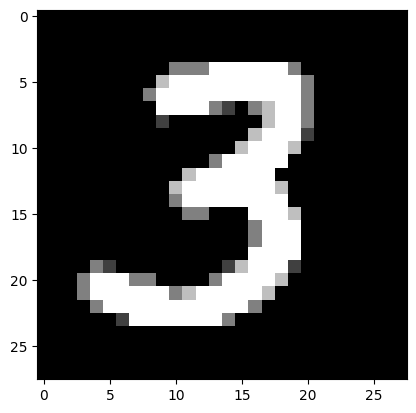

In [ ]:
i=np.random.randint(0,6000)
#print(i)
print(y_train[i])
plt.imshow(X_train[i],cmap='gray');

In [ ]:
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train[0].min(),X_train[0].max()

(0.0, 255.0)

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
X_train[0].min(),X_train[0].max()

(-1.0, 1.0)

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
buffer_size/batch_size #mini batch

234.375

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

This code transforms X_train (which is typically a large dataset) into a tf.data.Dataset object, shuffles the data with a buffer size of buffer_size, and groups it into batches of size batch_size for efficient training. This is a typical preprocessing step before feeding data into a TensorFlow model.

In [ ]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Building the Generator

Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/

Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/

Activation Function: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [ ]:
 7 * 7 * 256

12544

In [ ]:
# 100 -> 12544
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7, 7, 256)))

  # 7 * 7 * 128
  network.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14 * 14 * 64
  network.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28 * 28 * 1
  network.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  network.summary()

  return network

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [ ]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 2.58201901e-02,  1.66712523e+00,  6.44854963e-01,
        -1.50575566e+00,  1.84651569e-01,  8.34921956e-01,
         1.43164301e+00,  1.19318652e+00, -6.16485178e-01,
        -1.36483476e-01,  1.03815854e+00,  1.17215765e+00,
         1.63678586e+00,  1.55778108e-02,  6.63288891e-01,
         2.81962100e-02, -2.96696454e-01,  1.06325173e+00,
         2.06178570e+00, -5.89491487e-01, -3.36791277e-01,
         5.01634896e-01,  1.57150492e-01, -2.09541559e+00,
         1.70721069e-01, -3.99005502e-01,  9.28068638e-01,
        -4.61921632e-01, -4.39062327e-01,  1.98314413e-01,
        -4.77660477e-01,  4.58715469e-01,  4.38620389e-01,
         1.39519358e+00,  1.01334405e+00,  3.63803446e-01,
         7.38408208e-01, -1.81452066e-04, -9.94157568e-02,
         6.68871582e-01,  4.11802649e-01, -1.75727034e+00,
         1.54439771e+00,  1.25197208e+00, -1.03362784e-01,
        -3.20987225e-01, -7.27944434e-01, -1.38766539e+00,
      

In [ ]:
generator_image = generator(noise, training=False)

In [ ]:
generator_image.shape

TensorShape([1, 28, 28, 1])

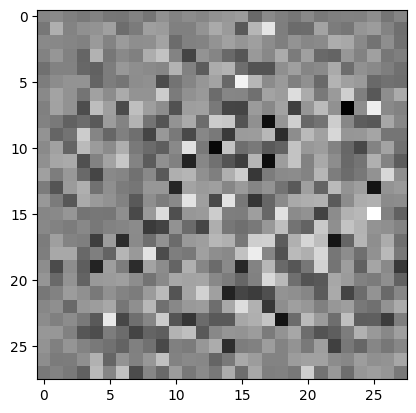

In [ ]:
plt.imshow(generator_image[0, :, :, 0], cmap='gray');

# Building the Discriminator

Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()

  #14X14X64
  network.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  #7X7X128
  network.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network


In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
 7 * 7 * 128

6272

In [ ]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [ ]:
discriminator(generator_image, training =False) #logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00086714]], dtype=float32)>

In [ ]:
tf.sigmoid(0.00205972)        # pass the above values

<tf.Tensor: shape=(), dtype=float32, numpy=0.5005149>

# Error calculation

Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

This method quantifies how well the discriminator is able to distinguish real images from fakes images. It compares the discriminator predictions on real images with an array of 1s and the discriminator predictions on fake (generated) images with an array of 0s

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [ ]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Training the GAN and Visualizing the results

Based on: https://www.tensorflow.org/beta/tutorials/generative/dcgan

@tf.function: https://www.tensorflow.org/guide/function#:~:text=You%20can%20use%20tf.,is%20required%20to%20use%20SavedModel%20.

In [ ]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
epochs = 100
noise_dimension = 100
nummber_of_images = 16

In [ ]:
batch_size,noise_dimension

(256, 100)

In [ ]:
@tf.function
#This decorator tells TensorFlow to compile the fonction into a graph,
#which improves performance by optimizing the execution,
#especially on large datasets on when training over many iterations.
def train(images):
        noise = tf.random.normal([batch_size, noise_dimension])
        #print(noise.shape)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          # tf.GradientTape(): TensorFlow's GradientTape is used to record operations s
          # for automatic differentiation. In this case, two tapes are used to
          # separately track the computations for the generator (gen_tape)
          # and discriminator (disc_tape).
          # This is crucial because both networks need to be trained simultaneously but independently.
          generated_images= generator(noise, training=True)

          expected_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(expected_output, fake_output)

          # generator(noise, training-True): The generator takes the random noise
          # as input and produces generated_images. The training True flag ensures
          # that any training-specific behavior (like dropout) is activated.


          # discriminator(images, training=True): The discriminator takes the real images
          # from the dataset and produces expected_output, which is its prediction
          # about the realness of the images.

          # discriminator(generated_images, training=True): The discriminator also
          # evaluates the generated images produred by the generator and outputs
          # fake_output, which is its prediction about the realness of the fake images.

          generato_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
          discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
          # gen_tape.gradient: Computes the gradients of the gen_loss with respect to
          # the generator's trainable variables (its weights and biases).
          # These gradients will be used to update the generator.

          # disc_tape.gradient: Computes the gradients of the disc_loss with respect
          # to the discriminator's trainable variables.
          # These gradients will be used to update the discriminator.

          generator_optimizer.apply_gradients(zip(generato_gradients, generator.trainable_variables))
          discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
          # generator_optimizer.apply_gradients: This applies the computed gradients
          # to update the generator's parameters, using the generator_optimizer.
          # The zip(generator_gradients, generator.trainable_variables) pairs each gradient
          #with the corresponding trainable variable.


          #discriminator_optimizer.apply_gradients: Similarly, this updates the discriminator

In [ ]:
epochs = 100
noise_dimension = 100
nummber_of_images = 16

In [ ]:
batch_size,noise_dimension

(256, 100)

In [ ]:
test_images=tf.random.normal([nummber_of_images, noise_dimension])
test_images.shape

TensorShape([16, 100])

In [ ]:
tf.config.run_functions_eagerly(True)
X_train_batch= X_train.as_numpy_iterator().next()
train(X_train_batch)

# Purpose : this line configures Tensorflow to run functions eagerly.
# even if they are decorated with @tf.function.
# What is Eager Execution?: In eager execution, TensorFlow operations are
#executed inmediately as Python operations (like normal Python code) (x)
# Werather than being compiled into a graph. This is helpful for debugging
#because it allows you to step through operations and inspect #intermediate values.
#why use run functions_eagerly (True)?: By default,
#TensorFlow compiles @tf.function decorated code into a graph for efficiency.
#However, if you need to debug your training process or check intermediate
#results (like inspecting gradients, losses, etc.), you can enable seager execution.
#This makes TensorFlow behave more like regular Python code #and simplifies debugging.

In [ ]:
test_images=tf.random.normal([nummber_of_images, noise_dimension])
test_images.shape

TensorShape([16, 100])

In [ ]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

In [ ]:
train_gan(X_train, epochs, test_images)

KeyboardInterrupt: 

**dataset**: The input dataset used for training, typically a set of images,

**epochs**: The number of training iterations (how many times the model should go through the dataset),

**test images**: A set of test images used to generate output during the training process for visualizing the progress. Inside the epoch loop, another loop runs through each image_batch in the dataset.

**train(image batch):** This is a placeholder for the training function that handles training the GAN. After every epoch, it prints the current epoch number.

**generator(test_images, training=False):** This calls the generator model with test images to generate new images. The argument training-False indicates that the generator is in inference mode, so it won't apply training-related operations like dropout.

**fig = plt.figure(figsize=(10,10))**: Creates a figure for

In [ ]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

      print('Epoch:',epoch + 1)
      generator_image = generator(test_images, training=False)
      fig=plt.figure(figsize=(10,10))
      for i in range(generator_image.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(generator_image[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
      plt.show()